# Introduction

We have a hypothetical source of ecommerce transactional data that we are going to use to identify fraudulent activities like using stolen credit cards, laudering money, etc.  

For this exercise we're going to build a machine learning model to predict the probability that the first transaction of a new user is fraudulent.  So for a user coming to the ecommerce site, predict the probability that they're here to perform a fraudulent activity.

Then we're going to explain how our model makes predictions, explain the costs of false positives/negatives, explain the users likely to raise flags and their characteristics, and offer a solution to how we productize it.

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn.utils import shuffle
# Importing Machine learning models library used for classification
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
from scipy.stats import skew, skewtest
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

# Run KM Survival Analysis
from lifelines.estimation import KaplanMeierFitter
#Run Cox Proportional Hazards
from lifelines import CoxPHFitter


from sklearn.utils import shuffle
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, Perceptron
import datetime
# Importing Machine learning models library used for classification
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
# import the class
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn import metrics

from sklearn.cross_validation import cross_val_score
from sklearn import metrics
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
fraud = pd.read_csv('../data/Fraud_Data.csv')
ips = pd.read_csv('../data/IpAddress_to_Country.csv')

In [4]:
fraud.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1


In [5]:
ips.head(3)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China


In [6]:
ips[(ips.lower_bound_ip_address <= 732758369) & (ips.upper_bound_ip_address>= 732758369)]

,lower_bound_ip_address,upper_bound_ip_address,country
4554,729808896.0,734003199,Japan


Let's create a country dictionary for ourselves with the upper and lower bound ipaddresses as our keys.  This will allow us to then check and add the country that the ip address in our fraud dataframe belongs to


In [7]:
# ip_country_dict = {}
# for i in range(len(ips)):
#     value = ips['country'][i]
#     key = (ips['lower_bound_ip_address'][i], ips['upper_bound_ip_address'][i])
#     ip_country_dict[key] = value

In [8]:
def map_country(row, ip_country_dict):
    ip_country = row['ip_address']
    for key in ip_country_dict:
        if ip_country >= key[0] and ip_country <= key[1]:
            return ip_country_dict[key]

In [9]:
# fraud['country'] = fraud.apply(lambda row : map_country(row, ip_country_dict), axis = 1)
# fraud.to_csv('combined_fraud.csv')

In [10]:
df = pd.read_csv('../data/combined_fraud.csv')

In [11]:
df = df.drop('Unnamed: 0', axis=1)

In [12]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [13]:
df['signup_time']=pd.to_datetime(df['signup_time'])
df['purchase_time']=pd.to_datetime(df['purchase_time'])

In [14]:
df['device_usage']=df['device_id'].map(df['device_id'].value_counts())
df['ip_usage']=df['ip_address'].map(df['ip_address'].value_counts())

New features

1.Difference between signup time and purchase time

2.Count of user id's using the same device

3.Count of user id's from the same IP address

In [15]:
df['time_to_purchase'] = (df['purchase_time'] - df['signup_time']).dt.seconds

In [16]:

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['Left', 'Stayed']):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 12)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 12)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in range(0,width):
        for y in range(0,height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                                foreground='black'), path_effects.Normal()])
    return


def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)


def model_building(dframe,X,y, pred_model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    print("Building model %s" %pred_model)
    if pred_model == 'Random Forest':
        modl = RandomForestClassifier(class_weight={0:.90,1:.10})
    elif pred_model == 'SVM Linear':
        modl = SVC(kernel='linear')
    elif pred_model == 'SVM RBF':
        modl = SVC(kernel='rbf')
    elif pred_model == 'Logistic Regression':
        modl = LogisticRegression(class_weight={0:.90,1:.10})
    elif pred_model == 'kNN':
        ref_score = -99
        nbr_neighbors = -9
        for k in range(2,10):
            print("In loop for %s neighbors" %k)
            modl = KNeighborsClassifier(n_neighbors=k)
            modl.fit(X_train, y_train)
            modl.predict(X_test)
            if modl.score(X_test, y_test) > ref_score:
                ref_score = modl.score(X_test, y_test)
                nbr_neighbors = k

        modl = KNeighborsClassifier(n_neighbors=nbr_neighbors)
        print("%s is the optimal number of neighbors" %nbr_neighbors)

    modl.fit(X_train, y_train)
    y_pred = modl.predict(X_test) 

    if pred_model == 'Random Forest':
        labels = list(dframe.columns.values)
        labels.remove('class')
        feat_importance = pd.DataFrame(modl.feature_importances_, columns=['values'])
        feat_importance['index'] = labels
        feat_importance = feat_importance.set_index('index')
        feat_importance = feat_importance.sort_values(['values'], ascending=False)
        print("Features importance: %s" %feat_importance)

    print("Accuracy for %s = %s" %(pred_model, round(100.*modl.score(X_test, y_test), 2)))
    print confusion_matrix(y_test, y_pred)
    
    ####
    logit = y_pred
    y_pred_prob = modl.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Fraud')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Not Fraud', 'Fraud'], cmap=plt.cm.Greens) 
    # Roc_curve for Logistic Regression Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic for Fraud', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()
    
def plot_variables(variable_list, file_location='../figures/categorical_vars.png'):
    plt.rcParams['figure.figsize'] = (16, 14)
    for i,j in itertools.izip_longest(variable_list,range(len(variable_list))): # itertools.zip_longest for to execute the longest loop
        plt.subplot(np.ceil(len(variable_list)/2),2,j+1)
        plt.subplots_adjust(hspace=.5)
        sns.countplot(x=i,data = df)
        plt.xticks(rotation=45)
        plt.title(str("No. of Users by "+i.title()))
        # Get current axis on current figure
        ax = plt.gca()

        # Iterate through the list of axes' patches
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                    fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig(file_location)

In [17]:
df.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_usage,ip_usage,time_to_purchase
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,1


In [18]:
df.describe()

,user_id,purchase_value,age,ip_address,class,device_usage,ip_usage,time_to_purchase
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646,1.684367,1.602719,40942.584427
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336,2.616954,2.596240,26049.661902
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000,1.000000,1.000000,1.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000,1.000000,1.000000,18100.750000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000,1.000000,1.000000,40874.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000,1.000000,1.000000,63504.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000,20.000000,20.000000,86399.000000


In [20]:
# df.dtypes
df.select_dtypes(include=['object']).columns

Index([u'device_id', u'source', u'browser', u'sex', u'country'], dtype='object')

In [21]:
# df.dtypes
df.select_dtypes(include=['object']).columns[1:]

Index([u'source', u'browser', u'sex', u'country'], dtype='object')

In [22]:
categorical_vars = df.select_dtypes(include=['object']).columns[1:] 

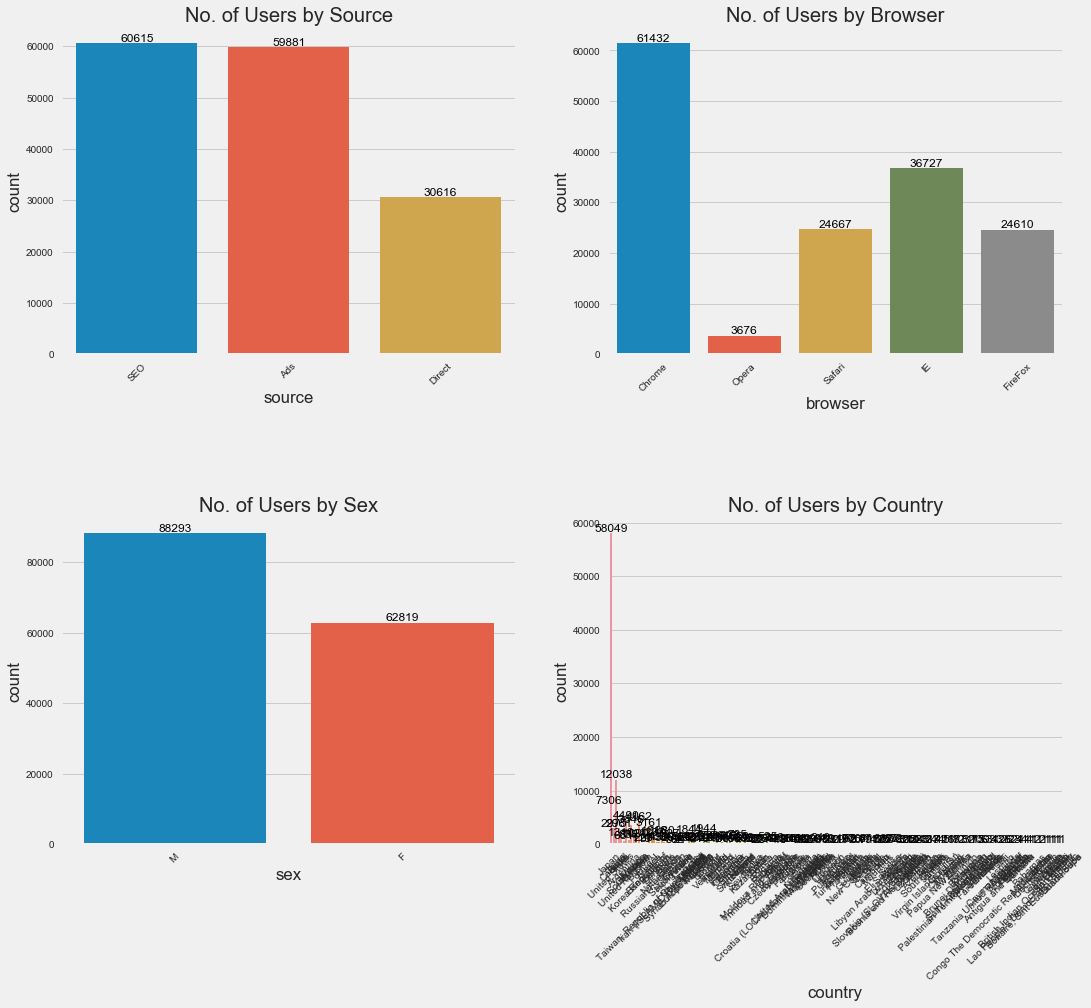

In [23]:
plot_variables(categorical_vars, file_location='../figures/categorical_vars.png')

Notes:
The country plot is a little crazy because of the large number of countries represented in that column, but we'll dig into that on it's own and see which have the highest fraud count.

It looks like the site is a Japan based site although there are other smaller user bases across the globe.

Our gender split is 60% male, 40% women roughly.


About 80% of the people visiting are coming in from SEO channels or Ad Channels, split equally into 40% and 40% respectively.

Chrome is the most popular browser, with internet explorer coming in second. That surprises me as I don't think it is 2nd in the market share overall.

In [24]:
df.select_dtypes(include=[np.number]).columns

Index([u'user_id', u'purchase_value', u'age', u'ip_address', u'class',
       u'device_usage', u'ip_usage', u'time_to_purchase'],
      dtype='object')

In [25]:
numeric_cols = ['purchase_value','age','class','device_usage','ip_usage','time_to_purchase']

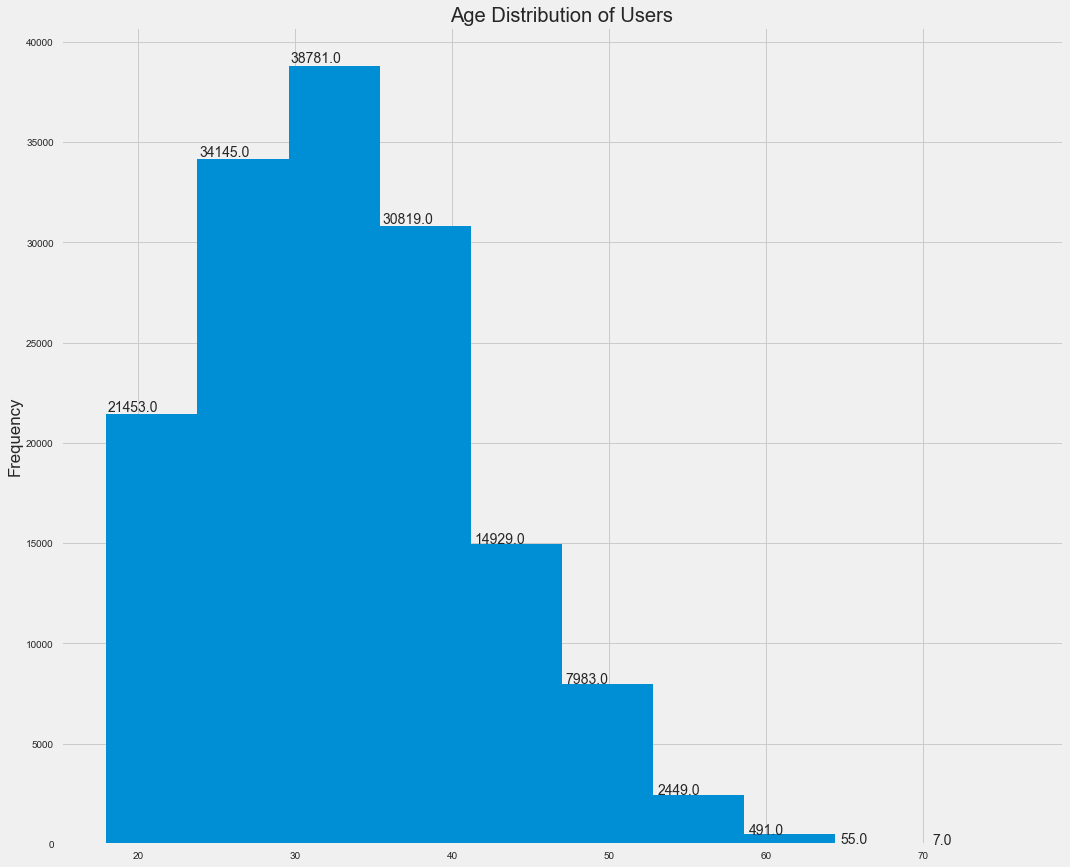

In [26]:
ax = df.age.plot(kind = 'hist', title = 'Age Distribution of Users')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/age_distribution_of_users.png')

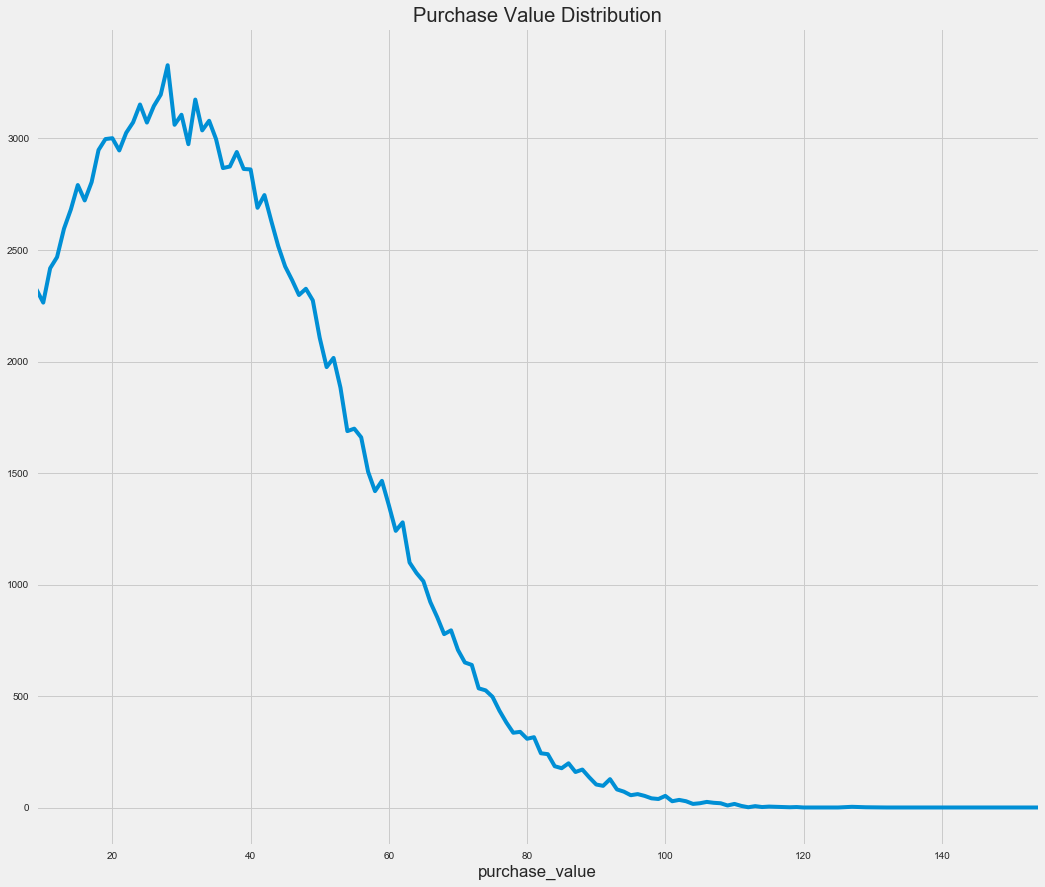

In [27]:
ax = df.groupby('purchase_value').size().plot(kind = 'line', title = 'Purchase Value Distribution')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig('../figures/purchase_value_distribution.png')

In [28]:
#choose which columns to use in our dataset
cols_to_use=['purchase_value', 'source', 'browser', 'sex', 'age', 'time_to_purchase', 'country', 'device_usage', 'ip_usage', 'class']

In [29]:
#switch to numerical IDs of the values we want to use (like pd.factorize)
for i in cols_to_use:
    if df[i].dtype=='object':
        df[i+'_codes']=pd.Categorical(df[i]).codes
        cols_to_use[cols_to_use.index(i)]=i+'_codes'

In [30]:
c_model = df[cols_to_use]
x_c = c_model.ix[:,c_model.columns != 'class']
y_c = df.ix[:,df.columns == 'class']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


In [33]:
print df['class'].value_counts()
print
print "Baseline"
print len(df[df['class']==0])*1.0*100/len(df)

0    136961
1     14151
Name: class, dtype: int64

Baseline
90.6354227328


/Users/bill_mac/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Building model Logistic Regression
Accuracy for Logistic Regression = 90.94
[[45180     2]
 [ 4516   169]]


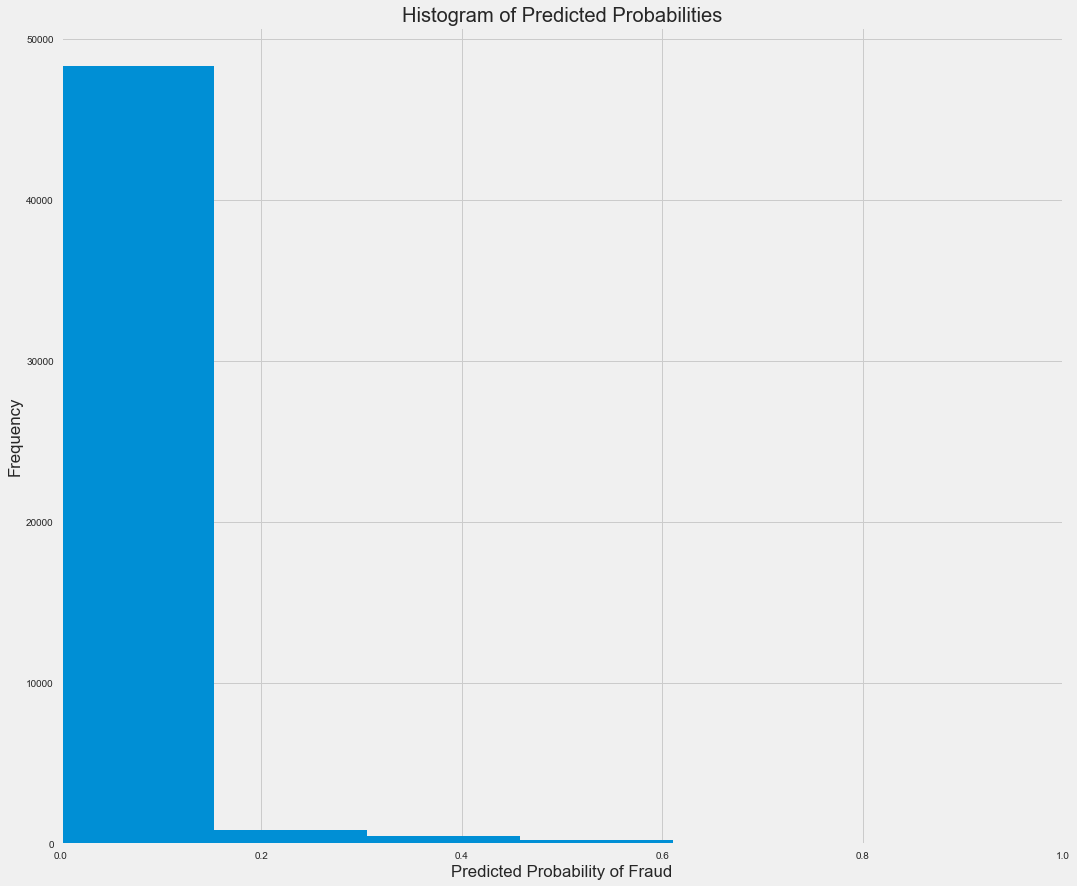

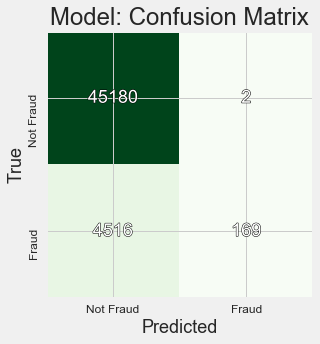

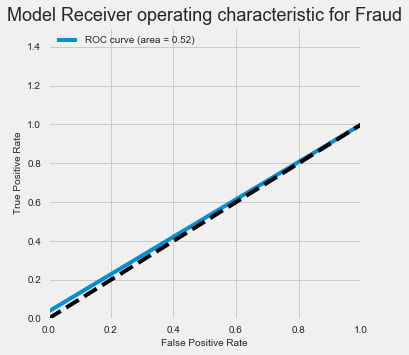

In [34]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [35]:
# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
purchase_value,-0.014866,6.943064e-01,False
source_codes,-0.014705,9.326606e-02,False
browser_codes,-0.018416,1.556262e-07,True
sex_codes,-0.006421,2.984293e-03,True
age,-0.058728,1.002992e-02,False
time_to_purchase,-0.000018,0.000000e+00,True
country_codes,-0.002580,4.480639e-04,True
device_usage,0.244823,0.000000e+00,True
ip_usage,0.221198,0.000000e+00,True


Now let's take a look at our logistic regression model, which predicts the probability of fraud.


We see 6 significant variables - Browser, Gender, Time to Purchase, Country, Device Usage, and IP Usage.


Browser, Sex, Time to Purchase, and Country - Slightly negative correlated coefficients, which in this case means it decreases the likihood of fraud

Device Usage - Positively correlated coefficients, which in this case means it increases the likelihood of fraud

In [36]:
categorical_vars

Index([u'source', u'browser', u'sex', u'country'], dtype='object')

In [37]:
source = pd.get_dummies(df.set_index('user_id')['source']) 
browser = pd.get_dummies(df.set_index('user_id')['browser']) 
sex = pd.get_dummies(df.set_index('user_id')['sex']) 


In [38]:
df = pd.merge(df, source.reset_index(), on='user_id')
df = pd.merge(df, browser.reset_index(), on='user_id')
df = pd.merge(df, sex.reset_index(), on='user_id')


In [41]:
#choose which columns to use in our dataset
cols_to_use = [
 'Ads',
 'Chrome',
 'time_to_purchase',
 'device_usage',
 'IE',
 'country_codes',
 'Safari',
 'SEO',
 'FireFox',
 'F',
 'Opera',
 'M',
 'class',
 'purchase_value',
 'Direct',
 'ip_usage',
 'age']

In [60]:
c_model = df[cols_to_use]
x_c = c_model.ix[:,c_model.columns != 'class']
y_c = df.ix[:,df.columns == 'class']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Logistic Regression
Accuracy for Logistic Regression = 90.92
[[45175     2]
 [ 4528   162]]


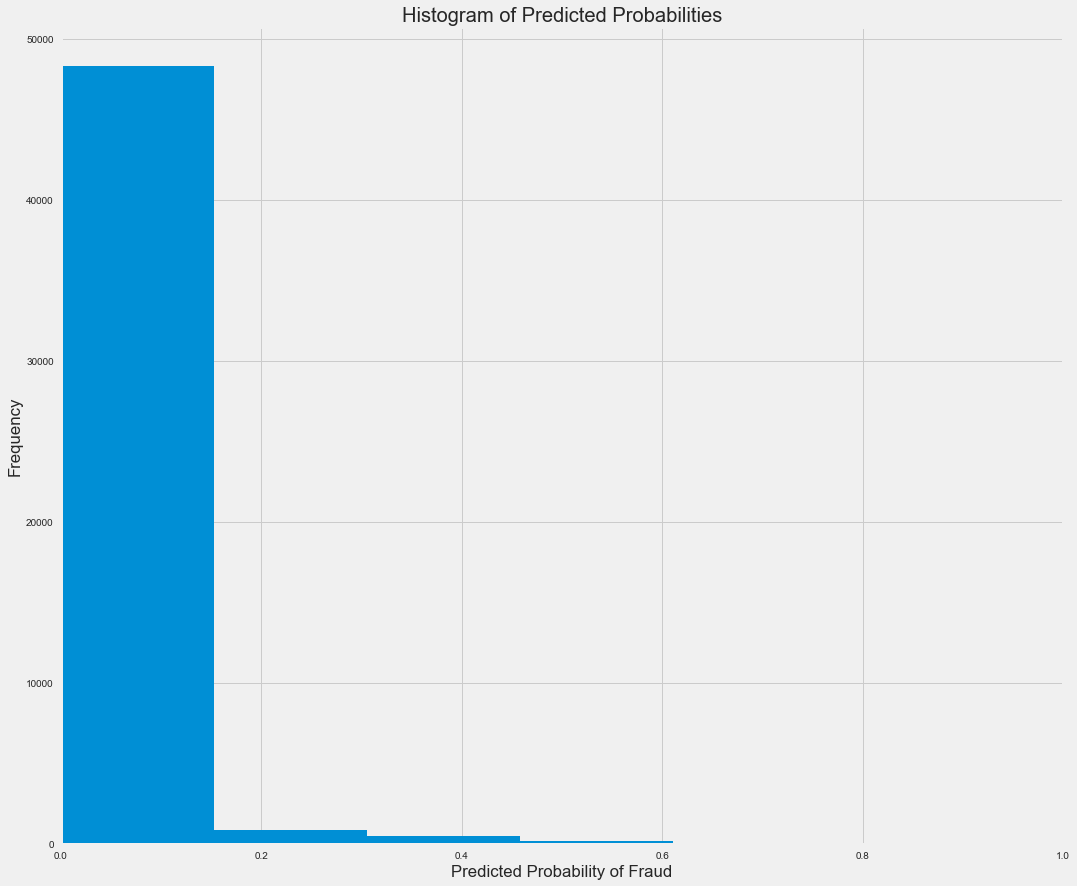

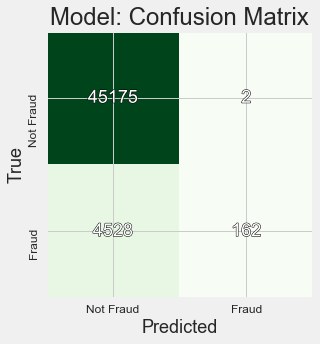

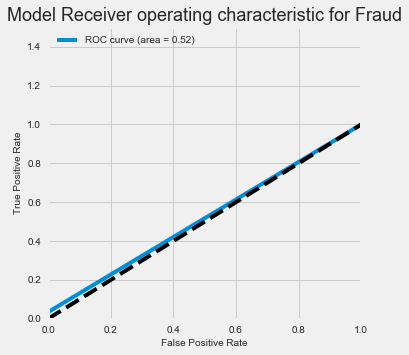

In [62]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [63]:
# run feature selection classifier on churn model
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
Ads,-0.006369,8.766993e-02,False
Chrome,-0.004160,1.318426e-08,True
time_to_purchase,-0.000018,0.000000e+00,True
device_usage,0.244221,0.000000e+00,True
IE,-0.004396,2.050448e-07,True
country_codes,-0.002600,4.480639e-04,True
Safari,-0.001900,4.237239e-02,False
SEO,-0.008283,1.913401e-06,True
FireFox,-0.002231,3.714078e-01,False
F,-0.006732,2.984293e-03,True


So now we are getting a clearer picture of the categorical features variables that are important and not important. 

For instance it doesn't look like Opera, Safari, or Firefox make a different on Fraud. Nor Does the Ad channel.

Building model Random Forest


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Features importance:                     values
index                     
time_to_purchase  0.522000
device_usage      0.117801
purchase_value    0.103736
age               0.087047
ip_usage          0.085843
country_codes     0.056241
Chrome            0.003834
FireFox           0.003430
IE                0.003369
M                 0.003070
Safari            0.002983
F                 0.002960
Ads               0.002886
SEO               0.002418
Opera             0.001377
Direct            0.001005
Accuracy for Random Forest = 95.43
[[44970   211]
 [ 2069  2617]]


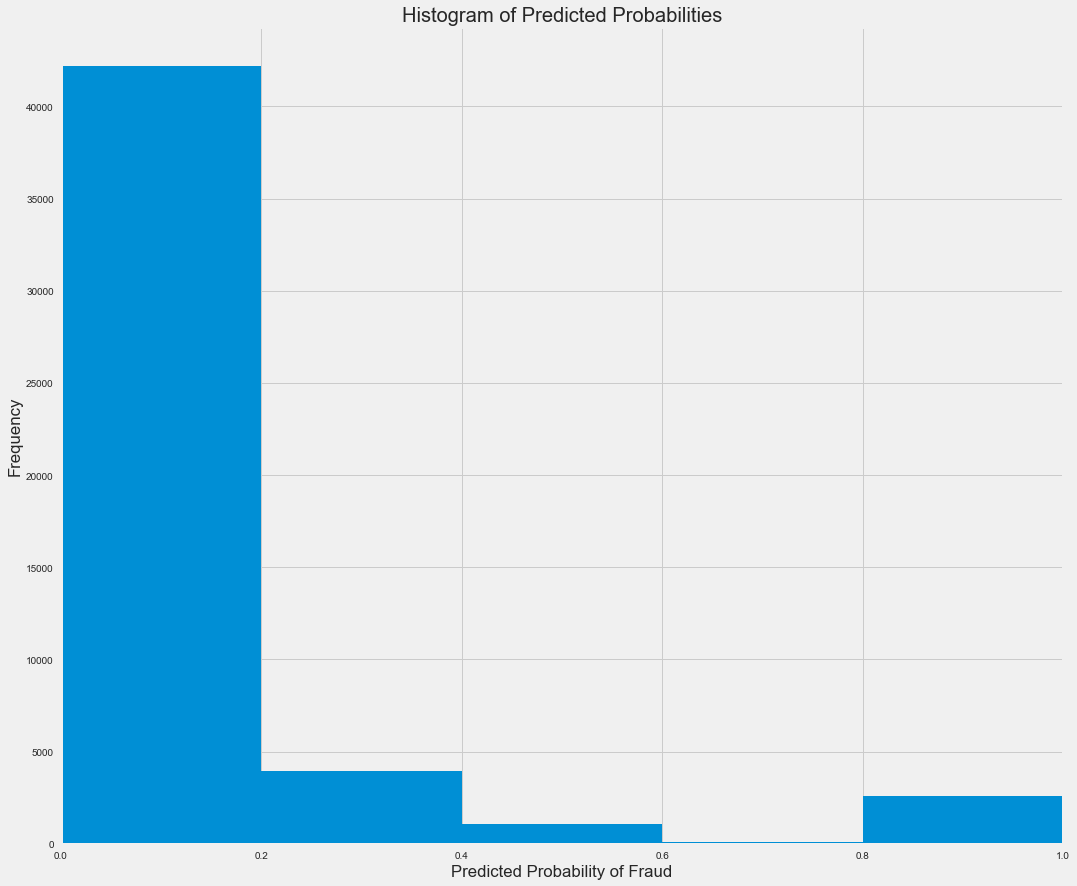

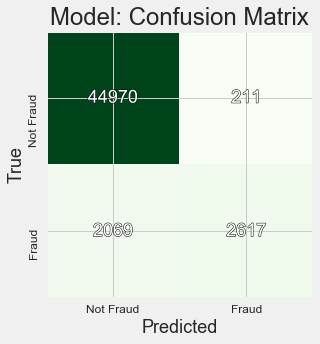

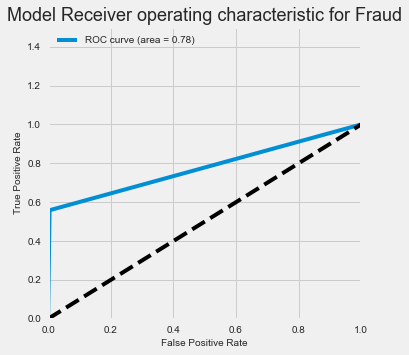

In [64]:
model_building(c_model, x_c,y_c , 'Random Forest')

In [79]:
statsigcols = list(r2[r2.sig == True].index)

In [81]:
statsigcols.append('class')

In [84]:
c_model2 = df[statsigcols]
x_c2 = c_model2.ix[:,c_model2.columns != 'class']
y_c = df.ix[:,df.columns == 'class']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Random Forest


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Features importance:                     values
index                     
time_to_purchase  0.857334
device_usage      0.058320
country_codes     0.040974
ip_usage          0.038106
Chrome            0.001468
IE                0.001232
F                 0.000759
M                 0.000733
SEO               0.000705
Direct            0.000369
Accuracy for Random Forest = 93.85
[[44108  1077]
 [ 1991  2691]]


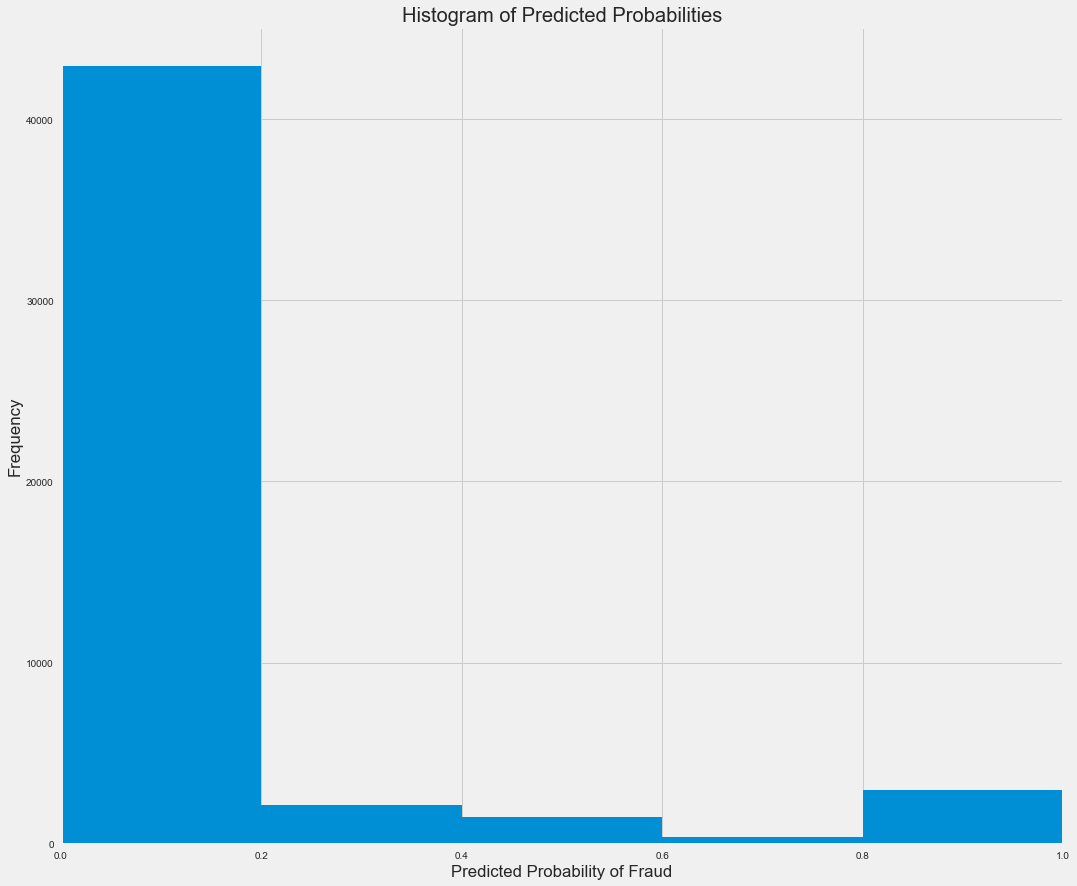

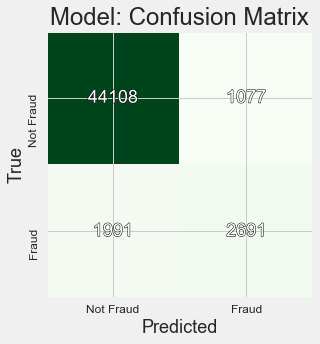

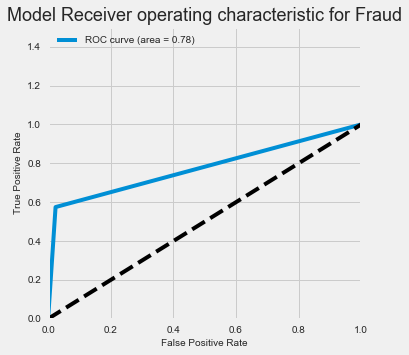

In [85]:
model_building(c_model2, x_c2,y_c , 'Random Forest')

To Do:
    * I believe grid searching over random forest parameters could improve our false negative / positive rate
    * We could also use PCA to lower the dimensions of our dataset

# Conclusion


In this type of exercise, we have to be very careful about how we handle false positive and negative rates because they impact our model differently and both come with associated costs.

False positives and negatives can be monumentally detrimental for certain business and applications. In this instance a misclassifiation could let fraudulent activites pass as normal and the companie loses money, and in other instances it can be life or death.  Consider a doctor running a test to see whether a patient had cancer.  If we tell the person they have cancer but they really don't, that's a mistake we can recover from. But if we tell a person they don't have cancer but they really do, that's death.

We obviously want to limit both false rates, but there's a trade off.  If we try to make our false positive rate 0 , we won't call any customer a fraudster and thus lose possible loyalty.  We obviously want to make our false negative rate 0 too so that the company doesn't lose money to fraud and that the brand doesn't become known as one that's rife with fraud.

---

The model we've chosen for this exercise is a Random Forest classifier, an ensemble method which constructs decision trees to determine and predict the classes of our traning examples.  We thus found the most important features which determine fraudulent instances, and used them as our dependent variables.  

The most important features are  
$time\_to\_purchase$, $device\_usage$,$country\_codes$,$ip\_usage$,$Chrome$,$IE$,$F$,$M$,$SEO$,and $Direct$

As noted before:

Browser, Sex, Time to Purchase, and Country - Have slightly negative correlated coefficients, which in this case means it decreases the likihood of fraud.

Device Usage - Positively correlated coefficients, which in this case means it increases the likelihood of fraud
For instance it doesn't look like Opera, Safari, or Firefox make a different on Fraud. Nor Does the Ad channel.

--- 

In the case that we put this fraud detection algorithm into production, we can do it by having real time input of user data from sources such as cookies or from other sources and predict whether we think this action from the user is fraud or not.  The preprocessing steps will run on our new user entry and output a class probability or likelihood probablity.  If the output is 'not fraud' we let the action through, but if it's fraud then we can potentially add another layer of security to make sure the person is who they say they are.
